In [26]:
experiment = "exp1"
sub_experiment = "constrained_zeph_25"

# Exploitation anaysis

## Links

In [27]:
from dataclasses import dataclass
from typing import Iterable, Iterator, Sequence

from diamond_miner.queries.query import UNIVERSE_SUBSET, CH_QUERY_SETTINGS, LinksQuery, links_table
from diamond_miner.typing import IPNetwork

@dataclass(frozen=True)
class GetLinksPrefixes(LinksQuery):
    """
    Return the links pre-computed in the links table.
    This doesn't group replies by probe protocol and probe source address,
    in other words, it assumes that the table contains the replies for a
    single vantage point and a single protocol.
    """

    def prefix_v4_to_v6(self, prefix):
        return "::ffff:" + str(prefix.network_address) 

    def group_elements(self, l, n):
        return [l[i:i + n] for i in range(0, len(l), n)]

    def execute_iter(
        self,
        url: str,
        measurement_id: str,
        prefixes: Iterable[IPNetwork],
        n_chunks: int
    ) -> Iterator:
        client = Client.from_url(url)
        prefixes_chunks = self.group_elements(list(prefixes), n_chunks)
        for prefixes in prefixes_chunks:
            for i, statement in enumerate(self.statements(measurement_id, prefixes)):
                rows = client.execute_iter(statement, settings=CH_QUERY_SETTINGS)
                for row in rows:
                    yield row

    def statements(
        self, measurement_id: str, prefixes: Iterable[IPNetwork]
    ) -> Sequence[str]:
        # Override this method if you want your query to return multiple statements.
        return (self.statement(measurement_id, prefixes),)

    def statement(
        self, measurement_id: str, prefixes: Iterable[IPNetwork]
    ) -> str:
        q =  f"""
        SELECT DISTINCT ({self.addr_cast('near_addr')}, {self.addr_cast('far_addr')})
        FROM {links_table(measurement_id)}
        WHERE {self.filters(UNIVERSE_SUBSET)}
        AND probe_dst_prefix IN [
        """
        q += ",".join([f"toIPv6('{self.prefix_v4_to_v6(prefix)}')" for prefix in prefixes])
        q += "]"
        return q

In [28]:
from clickhouse_driver import Client
from diamond_miner.queries import AddrType, GetLinks

database_name = "iris"
database_url = f"clickhouse://localhost/{database_name}"

def get_links_exploitation(measurement_id, prefixes, n_chunks):
    agent = measurement_id.split("__")[1].replace("_", "-")

    distinct_links = set()
    for link in GetLinksPrefixes(
        addr_type=AddrType.FixedString
    ).execute_iter(database_url, measurement_id, prefixes, n_chunks):
        distinct_links.add(link) 
    return distinct_links

In [29]:
from clickhouse_driver import Client
from diamond_miner.queries import AddrType, GetLinks

database_name = "iris"
database_url = f"clickhouse://localhost/{database_name}"

def get_links_total(measurement_uuid):
    tables = Client.from_url(database_url).execute_iter(
        f"SHOW TABLES FROM {database_name} LIKE "
        f"'results__{measurement_uuid.replace('-', '_')}%'"
    )
    tables = [table[0] for table in tables]
    measurement_ids = ["__".join(table.split("__")[1:]) for table in tables]

    distinct_links = set()
    for measurement_id in measurement_ids:
        for link in GetLinks(
            addr_type=AddrType.FixedString
        ).execute_iter(database_url, measurement_id):
            distinct_links.add(link) 
    return distinct_links

In [30]:
import pickle
from pathlib import Path

with Path(f"./resources/data/measurements/{experiment}/{sub_experiment}.txt").open("r") as fd:
    adaptive_uuids = fd.readlines()



In [31]:
total_n_links = []
for uuid in adaptive_uuids:
    total_n_links.append(len(get_links_total(uuid.strip())))

print(total_n_links)

[31966, 43756, 50352, 55753, 59497, 62591, 63587, 65781, 68351, 68579, 69382, 70745, 71169, 71194, 70624, 72081, 72630, 72733, 72361, 73401]


In [32]:
exploitation_n_links = [None]
for uuid in adaptive_uuids[1:]:
    uuid = uuid.strip()
    # Get exploitation prefixes 
    with Path(f"./resources/data/measurements/{experiment}/exploitation_{uuid}.pickle").open("rb") as fd:
        exploitation_prefixes = pickle.load(fd)
    
    cycle_n_links = set()
    for agent_uuid in exploitation_prefixes.keys():
        cycle_n_links.update(get_links_exploitation(f"{uuid}__{agent_uuid}", exploitation_prefixes[agent_uuid], 5000))
    exploitation_n_links.append(len(cycle_n_links))

print(exploitation_n_links)

[None, 31046, 42449, 49575, 54783, 58603, 61066, 62489, 65069, 66720, 67687, 68791, 69615, 69666, 69941, 70483, 70707, 71727, 71146, 71962]


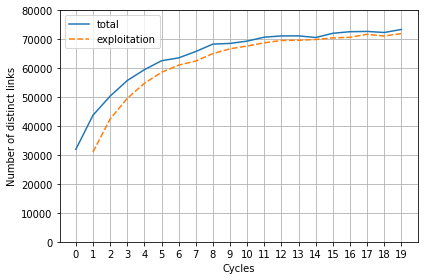

In [33]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

data = pd.DataFrame({
    "total": total_n_links,
    "exploitation": exploitation_n_links,
})

ax = sns.lineplot(data=data)

ax.set(xlabel="Cycles", ylabel="Number of distinct links")
ax.set(ylim=(0, 80_000))

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.grid()

plt.tight_layout()
plt.savefig("./resources/figures/exploitation_vs_total_links.pdf")
plt.show()

## Nodes

In [34]:
from dataclasses import dataclass
from typing import Iterable, Iterator, Sequence

from diamond_miner.queries.query import UNIVERSE_SUBSET, CH_QUERY_SETTINGS, LinksQuery, links_table
from diamond_miner.typing import IPNetwork

@dataclass(frozen=True)
class GetNodesPrefixes(LinksQuery):
    def prefix_v4_to_v6(self, prefix):
        return "::ffff:" + str(prefix.network_address) 

    def group_elements(self, l, n):
        return [l[i:i + n] for i in range(0, len(l), n)]

    def execute_iter(
        self,
        url: str,
        measurement_id: str,
        prefixes: Iterable[IPNetwork],
        n_chunks: int
    ) -> Iterator:
        client = Client.from_url(url)
        prefixes_chunks = self.group_elements(list(prefixes), n_chunks)
        for prefixes in prefixes_chunks:
            for i, statement in enumerate(self.statements(measurement_id, prefixes)):
                rows = client.execute_iter(statement, settings=CH_QUERY_SETTINGS)
                for row in rows:
                    yield row

    def statements(
        self, measurement_id: str, prefixes: Iterable[IPNetwork]
    ) -> Sequence[str]:
        # Override this method if you want your query to return multiple statements.
        return (self.statement(measurement_id, prefixes),)

    def statement(
            self, measurement_id: str, prefixes: Iterable[IPNetwork]
        ) -> str:
            q = f"""
            SELECT
                arrayJoin(
                    arrayDistinct(
                        arrayConcat(
                            groupUniqArray({self.addr_cast('near_addr')}),
                            groupUniqArray({self.addr_cast('far_addr')})
                        )
                    )
                )
            FROM {links_table(measurement_id)}
            WHERE {self.filters(UNIVERSE_SUBSET)}
            AND probe_dst_prefix IN [
            """
            q += ",".join([f"toIPv6('{self.prefix_v4_to_v6(prefix)}')" for prefix in prefixes])
            q += "]"
            return q

In [35]:
from clickhouse_driver import Client
from diamond_miner.queries import AddrType, GetLinks

database_name = "iris"
database_url = f"clickhouse://localhost/{database_name}"

def get_nodes_exploitation(measurement_id, prefixes, n_chunks):
    agent = measurement_id.split("__")[1].replace("_", "-")

    distinct_nodes = set()
    for link in GetNodesPrefixes(
        addr_type=AddrType.FixedString
    ).execute_iter(database_url, measurement_id, prefixes, n_chunks):
        distinct_nodes.add(link) 
    return distinct_nodes

In [36]:
from clickhouse_driver import Client
from diamond_miner.queries import AddrType, GetNodes

database_name = "iris"
database_url = f"clickhouse://localhost/{database_name}"

def get_nodes_total(measurement_uuid):
    tables = Client.from_url(database_url).execute_iter(
        f"SHOW TABLES FROM {database_name} LIKE "
        f"'results__{measurement_uuid.replace('-', '_')}%'"
    )
    tables = [table[0] for table in tables]
    measurement_ids = ["__".join(table.split("__")[1:]) for table in tables]

    distinct_nodes = set()
    for measurement_id in measurement_ids:
        for node in GetNodes(
            addr_type=AddrType.FixedString
        ).execute_iter(database_url, measurement_id):
            distinct_nodes.add(node) 
    return distinct_nodes

In [37]:
import pickle
from pathlib import Path

with Path(f"./resources/data/measurements/{experiment}/{sub_experiment}.txt").open("r") as fd:
    adaptive_uuids = fd.readlines()

In [38]:
total_n_nodes = []
for uuid in adaptive_uuids:
    total_n_nodes.append(len(get_nodes_total(uuid.strip())))

print(total_n_nodes)

[21432, 28412, 32598, 35417, 37476, 39260, 40053, 40959, 41999, 42357, 42825, 43523, 43766, 43891, 43872, 44295, 44344, 44636, 44646, 45019]


In [39]:
exploitation_n_nodes = [None]
for uuid in adaptive_uuids[1:]:
    uuid = uuid.strip()
    # Get exploitation prefixes 
    with Path(f"./resources/data/measurements/{experiment}/exploitation_{uuid}.pickle").open("rb") as fd:
        exploitation_prefixes = pickle.load(fd)
    
    cycle_n_nodes = set()
    for agent_uuid in exploitation_prefixes.keys():
        cycle_n_nodes.update(get_nodes_exploitation(f"{uuid}__{agent_uuid}", exploitation_prefixes[agent_uuid], 5000))
    exploitation_n_nodes.append(len(cycle_n_nodes))

print(exploitation_n_nodes)

[None, 21176, 28067, 32407, 35241, 37212, 38887, 39751, 40813, 41606, 42187, 42811, 43272, 43409, 43579, 43821, 43930, 44264, 44371, 44575]


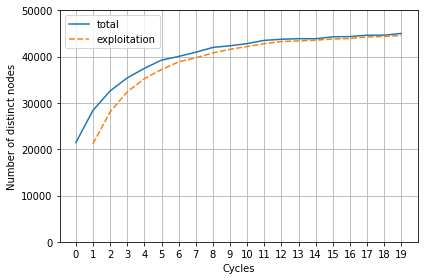

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns

data = pd.DataFrame({
    "total": total_n_nodes,
    "exploitation": exploitation_n_nodes,
})

ax = sns.lineplot(data=data)

ax.set(xlabel="Cycles", ylabel="Number of distinct nodes")
ax.set(ylim=(0, 50_000))

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.grid()

plt.tight_layout()
plt.savefig("./resources/figures/exploitation_vs_total_nodes.pdf")
plt.show()

## Budget

In [41]:
total_n_prefixes = []
for uuid in adaptive_uuids:
    uuid = uuid.strip()

In [42]:
exploitation_prefixes_ratio = [0]
for uuid in adaptive_uuids[1:]:
    uuid = uuid.strip()

    # Get total prefixes 
    with Path(f"./resources/data/measurements/{experiment}/prefixes_{uuid}.pickle").open("rb") as fd:
        total_prefixes = pickle.load(fd)
    total_n_prefixes = len(set.union(*[set(s) for s in total_prefixes.values()]))

    # Get exploitation prefixes 
    with Path(f"./resources/data/measurements/{experiment}/exploitation_{uuid}.pickle").open("rb") as fd:
        exploitation_prefixes = pickle.load(fd)
    exploitation_n_prefixes = len(set.union(*exploitation_prefixes.values()))

    exploitation_prefixes_ratio.append(exploitation_n_prefixes / total_n_prefixes)

print(exploitation_prefixes_ratio)

[0, 0.2628442395884256, 0.3471938195864576, 0.41227166276346605, 0.44255524196324086, 0.46629976899035197, 0.5067043543262941, 0.5189724251708697, 0.5578171523405087, 0.5465433278188131, 0.5666964005882494, 0.5720357401593817, 0.5694689632138938, 0.5755714936793879, 0.6106835327287967, 0.5565378482318731, 0.6043432469030543, 0.6047210833643931, 0.5776511103194395, 0.585102295648833]


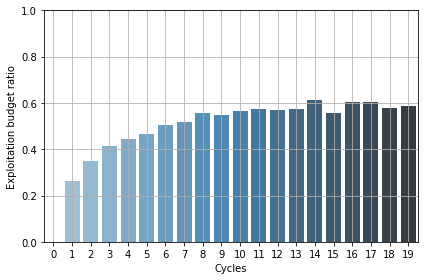

In [43]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns


ax = sns.barplot(x=list(range(len(exploitation_prefixes_ratio))), y=exploitation_prefixes_ratio, palette="Blues_d")

ax.set(xlabel="Cycles", ylabel="Exploitation budget ratio")
ax.set(ylim=(0, 1))

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.grid()

plt.tight_layout()
plt.savefig("./resources/figures/exploitation_fraction_budget.pdf")
plt.show()

# Impact of adding agent

## Links

In [44]:
from clickhouse_driver import Client
from diamond_miner.queries import AddrType, GetLinks
from collections import defaultdict

database_name = "iris"
database_url = f"clickhouse://localhost/{database_name}"

def get_links_total_per_agent(measurement_uuid):
    tables = Client.from_url(database_url).execute_iter(
        f"SHOW TABLES FROM {database_name} LIKE "
        f"'results__{measurement_uuid.replace('-', '_')}%'"
    )
    tables = [table[0] for table in tables]
    measurement_ids = ["__".join(table.split("__")[1:]) for table in tables]
    
    distinct_links = defaultdict(set)
    for measurement_id in measurement_ids:
        for link in GetLinks(
            addr_type=AddrType.FixedString
        ).execute_iter(database_url, measurement_id):
            distinct_links[measurement_id].add(link) 
    return distinct_links

In [45]:
total_links = []
for uuid in adaptive_uuids:
    links_per_agent = get_links_total_per_agent(uuid.strip())
    additive_links = []
    for _, links in links_per_agent.items():
        try:
            links_already_counted = set(additive_links[:-1])
        except IndexError:
            links_already_counted = set()
        additive_links.append(links_already_counted.union(links))
    total_links.append([len(l) for l in additive_links])

total_links_ordered = []
for a in range(len(total_links[0])):
    total_links_ordered.append([l[a] for l in total_links])


print(total_links_ordered)


[[18319, 25541, 30076, 33648, 36297, 37951, 38696, 39318, 40640, 40854, 41209, 42040, 42441, 42693, 43480, 43453, 44125, 44405, 43883, 44266], [17305, 22054, 24241, 26608, 28730, 30041, 31342, 32142, 34092, 33923, 34413, 34978, 35070, 35904, 35096, 34962, 35188, 35272, 34673, 35672]]


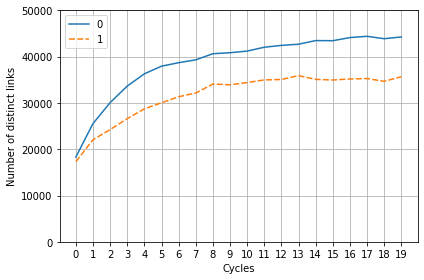

In [46]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns



ax = sns.lineplot(data=total_links_ordered)

ax.set(xlabel="Cycles", ylabel="Number of distinct links")
ax.set(ylim=(0, 50_000))

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.grid()

plt.tight_layout()
plt.savefig("./resources/figures/impact_adding_agents_links.pdf")
plt.show()

## Nodes

In [47]:
from clickhouse_driver import Client
from diamond_miner.queries import AddrType, GetNodes
from collections import defaultdict

database_name = "iris"
database_url = f"clickhouse://localhost/{database_name}"

def get_nodes_total_per_agent(measurement_uuid):
    tables = Client.from_url(database_url).execute_iter(
        f"SHOW TABLES FROM {database_name} LIKE "
        f"'results__{measurement_uuid.replace('-', '_')}%'"
    )
    tables = [table[0] for table in tables]
    measurement_ids = ["__".join(table.split("__")[1:]) for table in tables]

    distinct_nodes = defaultdict(set)
    for measurement_id in measurement_ids:
        for node in GetNodes(
            addr_type=AddrType.FixedString
        ).execute_iter(database_url, measurement_id):
            distinct_nodes[measurement_id].add(node) 
    return distinct_nodes

In [48]:
total_nodes = []
for uuid in adaptive_uuids:
    nodes_per_agent = get_nodes_total_per_agent(uuid.strip())
    additive_nodes = []
    for _, links in nodes_per_agent.items():
        try:
            nodes_already_counted = set(additive_nodes[:-1])
        except IndexError:
            nodes_already_counted = set()
        additive_nodes.append(nodes_already_counted.union(links))
    total_nodes.append([len(l) for l in additive_nodes])

total_nodes_ordered = []
for a in range(len(total_nodes[0])):
    total_nodes_ordered.append([l[a] for l in total_nodes])

print(total_nodes_ordered)

[[12936, 17696, 20809, 23003, 25163, 26298, 26871, 27165, 27932, 28180, 28371, 28909, 29215, 29478, 30412, 30060, 30292, 30936, 30694, 30940], [12261, 15171, 17014, 18547, 19733, 20461, 21774, 21779, 22785, 23022, 23475, 23847, 23871, 24727, 24427, 23777, 23955, 24066, 23665, 24142]]


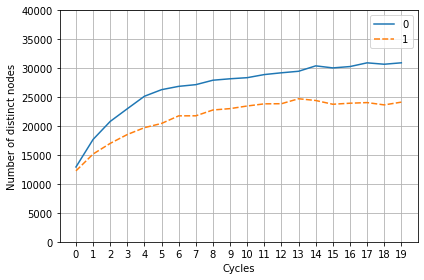

In [49]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns



ax = sns.lineplot(data=total_nodes_ordered)

ax.set(xlabel="Cycles", ylabel="Number of distinct nodes")
ax.set(ylim=(0, 40_000))

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.grid()

plt.tight_layout()
plt.savefig("./resources/figures/impact_adding_agent_nodes.pdf")
plt.show()